## User Example

This notebook outlines the steps needed to use Syndat to generate a set of reduced experimental Transmission data for evaluating total neutron cross sections.

In [1]:
import numpy as np
import syndat
import pandas as pd
import os
from matplotlib.pyplot import *

In [2]:
%matplotlib widget

### Define the particle-pair of interest

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1      # highest order l-wave to consider

Ta_pair = syndat.particle_pair(ac, M, m, I, i, l_max)

Ta_pair.map_quantum_numbers(True)
# Ta_pair.Jp 


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for negative parity
(J-, #Chs, l-waves)
(2.0, 1, [1.0])
(3.0, 2, [1.0, 1.0])
(4.0, 2, [1.0, 1.0])
(5.0, 1, [1.0])

Spin group data for positive parity
(J+, #Chs, l-waves)
(3.0, 1, [0.0])
(4.0, 1, [0.0])


### Define an energy grid and average resonance parameters

* Note that defining a linear energy grid will result in a wild binning stucture in tof. Consider defining a tof grid instead. In practice, the tof grid has a handful (5 or so) different bin widths and a constant bin width between each point of compresssion. This is due to the artisinal nature of this process, a complicated binning stucture is less justifiable, difficult to store in EXFOR, and requires the use of a complicated resolution broadening function.

In [4]:
# # define energy grid in eV - note that this approach creates a crazy tof bin width structure
energy_grid = np.linspace(1,100,1000)

# spin groups here is equivalent to Ta_pair.Jp or Ta_pair.Jn
spin_groups = [ (3,1,[0]), (4,1,[0]) ]

average_parameters = pd.DataFrame({ 'dE'    :   [7.0, 15.0],
                                    'Gg'    :   [55.0, 55.0],
                                    'gn2'    :   [20.0, 10.0]  })


### Sample a ladder of resonances parameters

In [5]:
from syndat import sample_levels
from syndat import sample_widths

Erange = energy_grid

resonance_ladder = pd.DataFrame()
if len(average_parameters.dE) > 0:
    for ij, j in enumerate(spin_groups):

        # sample resonance levels for each spin group with negative parity
        [levels, level_spacing] = sample_levels.sample_RRR_levels(Erange, average_parameters.dE[ij])
        
        # a single radiative capture width is sampled w/large DOF because of many 'partial' radiative transitions to ground state
        # must divide average by the 2*DOF in order to maintain proper magnitude
        red_gwidth = sample_widths.sample_RRR_widths(levels, average_parameters.Gg[ij]/2000, 1000)
        Gwidth = 2*red_gwidth # Gbar = 2*gbar b/c P~1 for gamma channels

        # sample observable width as sum of multiple single-channel width with the same average (chi2, DOF=channels)
        red_nwidth = sample_widths.sample_RRR_widths(levels, average_parameters.gn2[ij]/j[1], j[1])
        E_Gn_gnx2 = pd.DataFrame([levels, Gwidth, red_nwidth, [j[0]]*len(levels), [j[1]]*len(levels), [j[2][0]]*len(levels) ], index=['E','Gg', 'gnx2', 'J', 'chs', 'lwave'])   
        assert len(j[2])==1, "Code does not consider multiple lwaves contributing to a spin group"
        resonance_ladder = pd.concat([resonance_ladder, E_Gn_gnx2.T])

# look at your resonance ladder
resonance_ladder
        

,E,Gg,gnx2,J,chs,lwave
0,1.664738,56.001660,24.844005,3.0,1.0,0.0
1,12.861940,53.144400,8.339055,3.0,1.0,0.0
2,26.691534,57.101408,86.320123,3.0,1.0,0.0
3,32.352580,57.269893,3.974812,3.0,1.0,0.0
4,37.946474,55.370217,1.619133,3.0,1.0,0.0
5,42.879058,51.707181,14.022456,3.0,1.0,0.0
6,46.092129,57.795837,33.333403,3.0,1.0,0.0
7,52.335873,58.789951,7.907888,3.0,1.0,0.0
8,65.671856,57.060133,109.718317,3.0,1.0,0.0
9,78.550868,56.663400,11.557244,3.0,1.0,0.0


### Calculate a theoretical cross section from the resonance ladder

The theoretical cross section can be caalculated using the syndat code. The output total cross section must be converted to a transmission and stored in a dataframe with keys "E" and "theo_trans" before it can be passed to the experiment. The experiment object turns a theoretical cross section to a corresponding set of experimental data.

Text(0.5, 0.01, 'Energy (eV)')

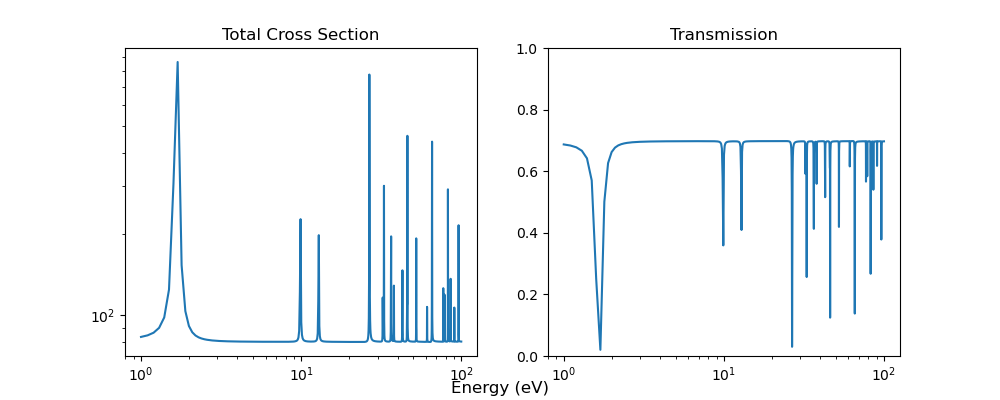

In [6]:

# SLWB with syndat
xs_tot, xs_scat, xs_cap = syndat.scattering_theory.SLBW(energy_grid, Ta_pair, resonance_ladder)

# convert to transmisison and put in an appropriate dataframe
n = 0.067166**2 # atoms per barn or atoms/(1e-12*cm^2)
trans = np.exp(-n*xs_tot)
theoretical_df = pd.DataFrame({'E':energy_grid, 'theo_trans':trans})

fig, ax = subplots(1,2, figsize=(10,4))
# ax[0].plot(energy_grid, xs_scat)
# ax[0].plot(energy_grid, xs_cap)
ax[0].plot(energy_grid, xs_tot)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Total Cross Section')

ax[1].plot(theoretical_df.E, theoretical_df.theo_trans)
ax[1].set_xscale('log')
ax[1].set_ylim([0,1])
ax[1].set_title('Transmission')

fig.supxlabel('Energy (eV)')

### Define an approximation to the open count rate spectra

An exponential function was fit to the open count rate from Brown, et al. This fitted function is used to approximate an open count rate spectra that would be seen in a similar tranmission tof experiment, however, storing it as a function allows the user to specify the energy grid and count time.

In [7]:
def open_count_rate(tof):
    return (2212.70180199 * np.exp(-3365.55134779 * tof*1e-6) + 23.88486286) 


# convert energy grid of interest to tof
tof = syndat.exp_effects.e_to_t(energy_grid,35.185,True)*1e6 # microseconds

# calculate a tof count rate spectra, convert to counts, 
cps_open = open_count_rate(tof)
bin_width = np.append(-np.diff(tof), -np.diff(tof)[-1])*1e-6
trig = 9760770
cts_open = cps_open*bin_width*trig
cts_open_noisy = syndat.pois_noise(cts_open)
cps_open_noisy = cts_open_noisy/bin_width/trig

open_dataframe = pd.DataFrame({'tof'    :   tof,
                                'bw'    :   bin_width,
                                'c'     :   cts_open_noisy,
                                'dc'    :   np.sqrt(cts_open_noisy)})


### Run the experiment & Analyze

The Syndat experiment object has a number of methods that generate raw count data from the theoretical cross section through a novel method developed by Walton, et al. The synthesized raw count data is then reduced to get an experimentally noise data with propagated uncertainty. This is stored in the "trans" attribute of the experiment object.

In practice, generally the transmission data is what is fit with R-Matrix theory. 

In [8]:
exp = syndat.experiment(True, True, True, open_dataframe, theoretical_df)

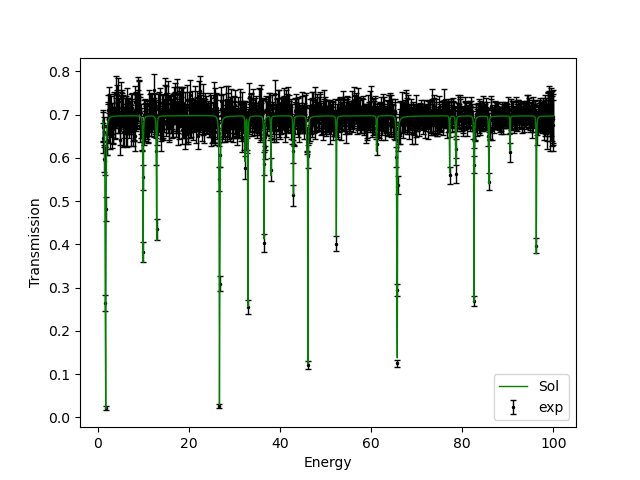

In [9]:
figure()
# plot(exp.trans.tof, exp.trans.exp_trans, '.', ms=1, label='exp')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

### Output in SAMMY format

The data in the experiment object can be accessed directly, or Syndat has a set of utilities to write (and read) SAMMY formatted data files.

In [12]:
syndat.write_samdat(exp.trans,"/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/postdoc_testdata/test_sammy.dat")